In [1]:
import time
start = time.process_time()
from obspy import read
import numpy as np
import glob
import os, math
import matplotlib.pyplot as plt
import h5py
import csv
from os.path import join

seed_path = r'../data/wave100'
pre_dir = '../data/prediction'
train_data_path = r'../data/train_data/'
seed_files = glob.glob(r'%s/*.seed' %seed_path) 
net_phases = np.load('../data/train_data/seismic_phase.npy',allow_pickle=True).item()

# 数据处理逻辑
1.读取文件名,波形数据和文件（事件）对应的震相数据
2.遍历波形
3.若该文件（事件）对应的震相数据中包含波形对应的台站，且其震相类型为P，则保存该数据
4.波形序列号为trn，P波到时为p_t,波形范围是[pt-10,pt+50]，故pt在截取后对应点为1001
5.预处理（去倾，滤波，归一化），滤波频带为[3,20]

In [2]:
trn = 0
for file in seed_files:
    fn=os.path.basename(file).split('.seed')[0]
    waves = read(file)
    event_phases = net_phases[fn]
    for tr in waves:
        if (event_phases.keys().__contains__(tr.stats.station)) \
        and (event_phases[tr.stats.station].keys().__contains__('P')):
            trn+=1
            now_st = tr.stats.station
            now_net = tr.stats.network
            tn = now_st + '.' + now_net + '_' + fn.split('.')[1] +'.'+ fn.split('.')[2] + '_EV'
            p_t = event_phases[now_st]['P']-8*3600
            start_time_str = (p_t-10).strftime('%Y-%m-%d %H:%M:%S.%f')
            temp_tr = tr.slice(p_t-10+0.01, p_t+50)
            temp_tr.detrend()
            temp_tr.filter("bandpass", freqmin=3.0,freqmax=20)
            temp_tr.normalize()
            td = temp_tr.data.reshape(1,6000)
            if (trn == 1):
                trs_data = np.zeros((1,6000))
                trs_data[0,:] = td
                trs_name_temp = []
                sts = []
            else:
                trs_data = np.concatenate((trs_data, td),axis = 0)
            trs_name_temp.append(tn)
            sts.append(start_time_str)
#         break
#     break
trs_data=trs_data.reshape(-1,3,6000)
trs_name = []
f = h5py.File("../data/prediction/traces.hdf5","w")
data = f.create_group('data')
for i in range(trs_data.shape[0]):
    trs_name.append(trs_name_temp[i*3])
    dsF = data.create_dataset(trs_name[i],data=trs_data[i,:,:].transpose(),dtype=np.dtype('<f4'))
    dsF.attrs["trace_name"] = trs_name[i]
    dsF.attrs["receiver_code"] = trs_name[i].split('.')[0]
    dsF.attrs["network_code"] = trs_name[i].split('.')[1].split('_')[0]
    dsF.attrs["receiver_latitude"] = '-999'
    dsF.attrs["receiver_longitude"] = '-999'
    dsF.attrs["receiver_elevation_m"] = '-999'
    dsF.attrs['trace_start_time'] = sts[i*3]
f.close()

In [3]:
csvfile = open(os.path.join(pre_dir, "traces.csv"), 'w',newline='')
output_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
output_writer.writerow(['trace_name'])
for i in range(trs_data.shape[0]):
    output_writer.writerow([trs_name[i]])
    csvfile.flush()
csvfile.close()

ZHX.GD_201701012309.0001_EV


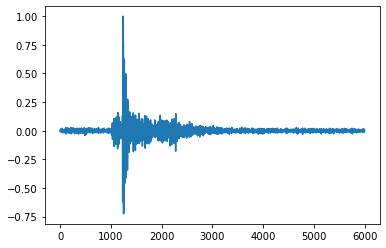

In [5]:
print(trs_name[4])
plt.plot(trs_data[4,0,:])